# Steepest Hill Climb
It refers to moving in the direction of steepest ascent of the reward-policy function. The 
method is not very good though as it may tend to get stuck in local maximas...

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
from collections import deque
%matplotlib inline 

# Agent class
We will work on the cartpole environment as its good for 1st time experimentations. 
* The policy is going to be a weights matrix which ouputs propabilities for each action. The propabilities 
will be generated using a $softmax$ function. Its given by 
![softmax](https://wikimedia.org/api/rest_v1/media/math/render/svg/02a859ba32ab892a2cdbfdafcd5a8f56e49e3d1c) 
Its normaly used in classification problems and hence is also suitable for this one.
* After every training loop, a set of noises will be added to the weights as a standard normal distribution. The 
```np.random.normal``` is used as we can contol the $mean$ and $standard$ deviation of it
* At every iteration of learning, the policy is tested and goes two ways
    * **If better  performance** the magnitude of the amount of the noise is reduced
    * **If worse performance** the magnitude of the noise  is increased 

In [18]:
class HillClimber:
    """Implements all the necessary methods for the algo"""
    def __init__(self, env):
        """
        Init all class variables
        :param env: The current environment
        """
        self.n_actions = env.action_space.n
        self.n_observations = env.observation_space.shape[0]
        self.policy = np.random.rand(self.n_observations, self.n_actions)  # Random Policy to start with
        self.best_policy = np.copy(self.policy)
        self.best_reward = -1
        self.noise = 0.5            # Scale of noise
        self.noise_max = 2
        self.noise_min = 0.001
        self.gamma = 0.98           # Discount factor
        
    def get_action(self, state, policy=None):
        """
        Gets the action from the policy weights
        :param state: Cuurent state present in as a tuple of size (1,4)
        :param policy: If passed, uses the passed policy...else uses self.policy
        :return: The action to be performed
        """
        if policy is None:
            actions = np.dot(state, self.policy)
        else:
            actions = np.dot(state, policy)
        actions = np.exp(actions)
        actions = actions / np.sum(actions)     # Softmax Implementation
        return np.argmax(actions)
            
    def _noise_adder(self, better):
        """
        Generates noise for the policy
        :param better: Condition to be performed for
        :return: None
        """
        if better:      # Noise on current policy
            self.policy += np.random.normal(
                loc=(self.noise_min + self.noise)/2,
                scale=(self.noise - self.noise_min),
                size=(self.n_observations, self.n_actions)
            )
        else:           # Noise on best policy
            self.policy = self.best_policy + np.random.normal(
                loc=(self.noise_min + self.noise)/2,
                scale=(self.noise - self.noise_min),
                size=(self.n_observations, self.n_actions)
            )
            
    def learn(self, discounted_reward):
        """
        Judges the performance of the policy and updates it accordngly
        :param discounted_reward: The return of the policy
        :return: None
        """
        if discounted_reward > self.best_reward:    # Reduce noise
            self.best_reward = discounted_reward
            self.best_policy = self.policy
            if self.noise > self.noise_min:
                self._noise_adder(better=True)
                self.noise = max(self.noise_min, self.noise/2)
        else:       # Increase noise
            if self.noise < self.noise_max:
                self._noise_adder(better=False)
                self.noise = min(self.noise_max, self.noise*1.1)
        
    def try_policy(self, env, evaluate=False):
        """
        Performs the environment testing loop
        :param env: Environment to be tested upon
        :param evaluate: Flag to toggle gamma. If true, actual reward. Else, discounted reward
        :return: Reward calculated
        """
        discounted_reward = 0
        state = env.reset()
        state = np.reshape(state, (1,self.n_observations))
        done = False
        time_steps = 0
        while not done:
            time_steps += 1
            action = self.get_action(state)
            next_state, reward, done, _ = env.step(action)
            if not evaluate:
                discounted_reward += (self.gamma ** time_steps) * reward
            else:
                discounted_reward += reward
                env.render()
            state = next_state
            state = np.reshape(state, (1,self.n_observations))
        return discounted_reward

# The environment handler

In [19]:
env = gym.make('CartPole-v1')
EPOCHS = 200
EVAL_FREQ = 5
agent = HillClimber(env)

Epoch : 0    Evaluation Score : 8.0    Noise Scale : 0.25
Epoch : 5    Evaluation Score : 8.0    Noise Scale : 0.18301250000000008
Epoch : 10    Evaluation Score : 9.0    Noise Scale : 0.29474346137500024
Epoch : 15    Evaluation Score : 10.0    Noise Scale : 0.47468729197905185
Epoch : 20    Evaluation Score : 9.0    Noise Scale : 0.7644886306051829
Epoch : 25    Evaluation Score : 9.0    Noise Scale : 0.5596439020345243
Epoch : 30    Evaluation Score : 49.0    Noise Scale : 0.40968731848437356
Epoch : 35    Evaluation Score : 80.0    Noise Scale : 0.13632345522567535
Epoch : 40    Evaluation Score : 47.0    Noise Scale : 0.09979558539795566
Epoch : 45    Evaluation Score : 116.0    Noise Scale : 0.07305535829057345
Epoch : 50    Evaluation Score : 76.0    Noise Scale : 0.1176563850805515
Epoch : 55    Evaluation Score : 83.0    Noise Scale : 0.08613035669821775
Epoch : 60    Evaluation Score : 63.0    Noise Scale : 0.13871380076604672
Epoch : 65    Evaluation Score : 58.0    Noise Sc

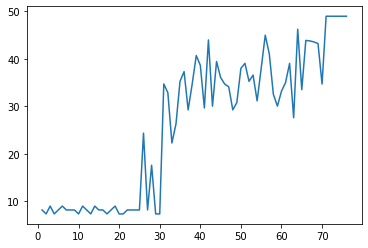

In [35]:
rewards_tracker = deque(maxlen=20)
all_rewards = []
for epoch in range(EPOCHS):
    discounted_reward = agent.try_policy(env)   # Test current policy
    all_rewards.append(discounted_reward)
    agent.learn(discounted_reward)              # Ajust noise scale and update policy
    if not epoch % EVAL_FREQ:                   # Evaluation of policy
        rewards_tracker.append(agent.try_policy(env, evaluate=True))
        print(f"Epoch : {epoch}    Evaluation Score : {rewards_tracker[-1]}    Noise Scale : {agent.noise}")
    if np.mean(rewards_tracker) > 195.0 or rewards_tracker[-1]==500:    # Stop Training
        print(f"Episode Solved in {epoch} epochs!")
        break
env.close()
plt.plot(np.arange(start=1,                 # Gnerate reward-v-episodes
                   stop=epoch+2,
                   step=1), all_rewards)

# Evaluation

In [22]:
env.close()

In [36]:
def evaluate(env):
    total_reward = 0
    state = env.reset()
    state = np.reshape(state, (1,agent.n_observations))
    done = False
    while not done:
        action = agent.get_action(state, policy=agent.best_policy)      # Use the best policy for evaluation
        next_state, reward, done, _ = env.step(action)
        env.render()
        total_reward += reward
        state = next_state
        state = np.reshape(state, (1,agent.n_observations))
    return total_reward

In [44]:
print(f"{evaluate(env)} Score of evaluation")
env.close()

500.0 Score of evaluation
